# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [140]:
# import libraries


# Data wrangling
import re
import numpy as np
import pandas as pd
import pickle


# Machine Learning

## NLTK
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# DataViz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_colwidth",-1)
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
df = pd.read_sql_table('MessageToCategories', con='sqlite:///DisasterResponse.db')
categories = df.columns[3:]
X = df[['message']].values[:,0]
y = df[categories].values

In [26]:
df[['message']].sample(10)

,message
22980,"In Sri Lanka, Direct Relief is working to provide secure, long-lasting access to clean drinking water in the most severely affected neighborhoods of the hard hit North and East coasts by funding the construction of wells."
19989,"Bulk food contributions to the country's 'Emergency Relief Needs' from international organizations, bi-lateral donors and NGOs are, for the most part, channelled through the DPPC with the funding organization playing a monitoring role."
3710,"A BIG SALUT FOR YOU ,PLEASE GIVE OUR PRESIDENT THIS MESSAGE FOR ME: HE HAS TO START WITH THE EDUCATION OF AGRICULTURE IN SCHOOL FOR THE YOUNGSTERS,IT WILL BE A TOTAL CHANGE FOR THE COUNTRY."
15392,"""It killed registered nurses and it can also kill practising nurses."
103,"URGENT ACTION NEEDED --this is follow up from previous SMS in regards to possible delivery... possible to deliver my baby in an other country, does not matter what it is.."
13824,"The prevailing situation in Afghanistan - with war ravaging the country, serious drought afflicting certain regions and living conditions rapidly deteriorating - only served to heighten fears about the fate of those returning, according to its Iranian head of mission, Francois Calas."
7340,Tell of the civil Officers to get converted and accept Jesus.
25085,"This morning, its local partner organisation, the De Laas Gul Foundation, sent out trucks containing food to the North Western Frontier Province."
22494,"Dao Xuan Nha, head of the Department of Agriculture and Rural Development says if floodwaters rise by 50-60cm, the devastation may affect 1,000 hectares of rice growing area in Hon Dat District."
24420,The Jakarta Flood Team has proposed relocating riverbank dwellers to low-cost apartments.


In [38]:
def tokenize(text, lemmatize=True):
    """
    Custom tokenizer for sklearn CountVectorizer 

    Args: 
    text: str,  raw text
    Return: 
    tokens: list of str, list of lemmatized tokens
    """
        
    # Post-processing pipeline
    
    # Text normalization: Lower case
    text = text.lower()
    
    # Text cleaning: Delete URLs
    
    regex = "(http[s]?://\S+)"
    text = re.sub(regex,"[URL]",text)
    
    # Text Tokenization
    tokens = word_tokenize(text)
        
    # Text cleaning
    
    ## Delete punctuation
    regex = re.compile("\W")
    tokens = [t for t in tokens if not regex.match(t)]
    
    ## Delete single caracters
    regex = re.compile("^[a-z]$")
    tokens = [t for t in tokens if not regex.match(t)]
    
    ## Delete numbers
    regex = re.compile("^[0-9]+\W*$")
    tokens = [t for t in tokens if not regex.match(t)]
        
    ## Delete stopwords
    tokens = [t for t in tokens if not t in stopwords.words("english")]
    
    # Text Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [39]:
%%time 
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)
print(f"The vocaulary contains {len(vect.vocabulary_.keys())} words")

The vocaulary contains 35271 words
CPU times: user 1min 41s, sys: 8.2 s, total: 1min 49s
Wall time: 1min 50s


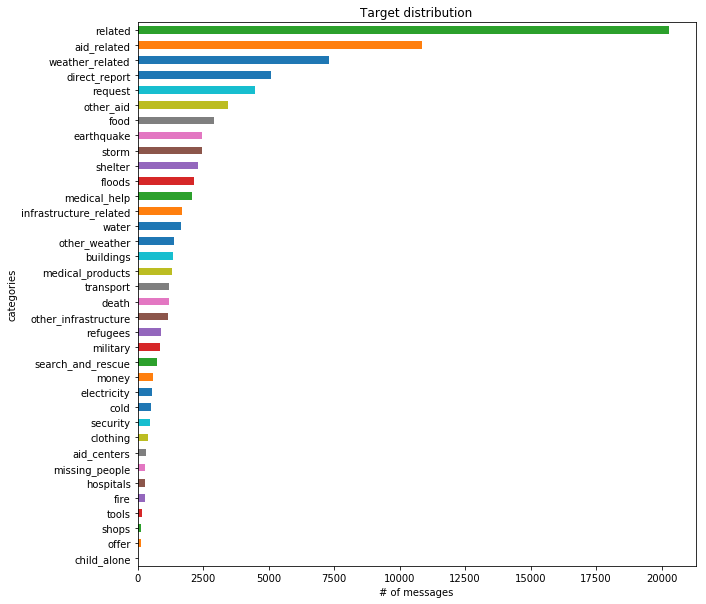

In [80]:
# Target distribution
plt.figure(figsize=(10,10))
data = df[categories].sum().sort_values(ascending=True)
data.plot.barh()
plt.title('Target distribution')
plt.ylabel('categories')
plt.xlabel('# of messages')
plt.show()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [91]:
pipeline = Pipeline([
    ('extractor', TfidfVectorizer(tokenizer=tokenize)),
    ('clf', MultiOutputClassifier(RandomForestClassifier(), n_jobs=-1))])

### 4. Train pipeline

In [110]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [111]:
%%time
pipeline.fit(X_tr, y_tr)

CPU times: user 2min 37s, sys: 6.8 s, total: 2min 43s
Wall time: 2min 44s


Pipeline(memory=None,
     steps=[('extractor', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...ob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=-1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [141]:
def evaluate(y_true, y_pred):
    """
    Mutlilabel classification report
    
    Args:
        y_true: np.array: ground truth labels
        y_pred: np.array: predicted labels
    Returns:
        report: pd.DataFrmae: classification report displaying model metrics per output
    """
    
    report = {"output":[],
              "accuracy":[],
              "precision":[],
              "recall":[],
              "f1":[]}
    for i in range(len(categories)):

        y_pred_i = y_pred[:, i]
        y_true_i = y_true[:, i]
        
        report["output"].append(categories[i])
        report["accuracy"].append(accuracy_score(y_pred_i,y_true_i))
        report["precision"].append(precision_score(y_pred_i,y_true_i, average='weighted'))
        report["recall"].append(recall_score(y_pred_i,y_true_i, average='weighted'))
        report["f1"].append(f1_score(y_pred_i,y_true_i, average='weighted'))
        
    return pd.DataFrame(report)

def custom_scorer(y_pred, y_true):
    
    report = evaluate(y_pred, y_true)
    
    return report.f1.median()

score = make_scorer(custom_scorer, greater_is_better=True)

In [112]:
%%time

# Evaluate model on train set
y_pred = pipeline.predict(X_tr)
training_report = evaluate(y_tr, y_pred)

CPU times: user 1min 29s, sys: 6.47 s, total: 1min 36s
Wall time: 1min 36s


In [115]:
training_report

,output,accuracy,precision,recall,f1
0,related,0.989844,0.989867,0.989844,0.989852
1,request,0.987459,0.988260,0.987459,0.987634
2,offer,0.998903,0.999172,0.998903,0.998979
3,aid_related,0.986267,0.986531,0.986267,0.986293
4,medical_help,0.987984,0.989790,0.987984,0.988436
5,medical_products,0.990797,0.992459,0.990797,0.991235
6,search_and_rescue,0.994660,0.995643,0.994660,0.994923
7,security,0.995136,0.996405,0.995136,0.995495
8,military,0.995375,0.995978,0.995375,0.995535
9,child_alone,1.000000,1.000000,1.000000,1.000000


In [116]:
%%time

# Evaluate model on test set
y_pred = pipeline.predict(X_test)
test_report = evaluate(y_test, y_pred)

CPU times: user 22.4 s, sys: 1.72 s, total: 24.2 s
Wall time: 24.3 s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [137]:
test_report.f1.median()

0.97347547004228696

### 6. Improve your model
Use grid search to find better parameters. 

In [121]:
pipeline.get_params()

{'memory': None,
 'steps': [('extractor',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7fc908791620>, use_idf=True,
           vocabulary=None)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None, verbos

In [157]:
%%time

parameters = {
    'clf__estimator__max_depth': [5,10]
}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=parameters,
                           cv=3,
                           verbose=4,
                           n_jobs=-1,
                           scoring=score)

grid_search.fit(X_tr, y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__max_depth=5, clf__estimator__n_estimators=10 ....


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=5, clf__estimator__n_estimators=10, score=0.9756400989745821, total= 1.5min
[CV] clf__estimator__max_depth=5, clf__estimator__n_estimators=10 ....


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=5, clf__estimator__n_estimators=10, score=0.9772133129342053, total= 1.5min
[CV] clf__estimator__max_depth=5, clf__estimator__n_estimators=10 ....


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=5, clf__estimator__n_estimators=10, score=0.9768735308198535, total= 1.5min
[CV] clf__estimator__max_depth=5, clf__estimator__n_estimators=100 ...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.5min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=5, clf__estimator__n_estimators=100, score=0.9756400989745821, total= 1.8min
[CV] clf__estimator__max_depth=5, clf__estimator__n_estimators=100 ...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=5, clf__estimator__n_estimators=100, score=0.9772133129342053, total= 1.8min
[CV] clf__estimator__max_depth=5, clf__estimator__n_estimators=100 ...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=5, clf__estimator__n_estimators=100, score=0.9768735308198535, total= 1.8min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=10 ...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=10, score=0.9756400989745821, total= 1.5min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=10 ...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=10, score=0.9772133129342053, total= 1.5min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=10 ...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=10, score=0.9768398455618221, total= 1.5min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.9756400989745821, total= 1.9min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.9772133129342053, total= 1.9min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.9768398455618221, total= 1.9min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 32.7min finished


CPU times: user 31min 47s, sys: 2min 16s, total: 34min 3s
Wall time: 34min 14s


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [161]:
grid_search.best_params_

{'clf__estimator__max_depth': 5, 'clf__estimator__n_estimators': 10}

In [162]:
%%time

# Evaluate model on train set
y_pred = grid_search.predict(X_tr)
train_report = evaluate(y_tr, y_pred)

# Evaluate model on train set
y_pred = grid_search.predict(X_test)
test_report = evaluate(y_test, y_pred)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


CPU times: user 1min 45s, sys: 8.16 s, total: 1min 53s
Wall time: 1min 54s


In [166]:
train_report

,output,accuracy,precision,recall,f1
0,related,0.761158,1.000000,0.761158,0.864383
1,request,0.829058,1.000000,0.829058,0.906541
2,offer,0.995518,1.000000,0.995518,0.997754
3,aid_related,0.612579,0.960896,0.612579,0.728189
4,medical_help,0.921133,0.999905,0.921133,0.958852
5,medical_products,0.949933,0.999905,0.949933,0.974229
6,search_and_rescue,0.971009,1.000000,0.971009,0.985291
7,security,0.981356,1.000000,0.981356,0.990590
8,military,0.966765,0.999952,0.966765,0.983054
9,child_alone,1.000000,1.000000,1.000000,1.000000


In [167]:
test_report

,output,accuracy,precision,recall,f1
0,related,0.752050,1.000000,0.752050,0.858480
1,request,0.830441,1.000000,0.830441,0.907367
2,offer,0.995422,1.000000,0.995422,0.997706
3,aid_related,0.620256,0.957062,0.620256,0.731972
4,medical_help,0.918367,1.000000,0.918367,0.957447
5,medical_products,0.950219,1.000000,0.950219,0.974474
6,search_and_rescue,0.977875,1.000000,0.977875,0.988814
7,security,0.984742,1.000000,0.984742,0.992312
8,military,0.969102,1.000000,0.969102,0.984308
9,child_alone,1.000000,1.000000,1.000000,1.000000


In [173]:
print("Train: median F1 score across outputs {:.4f}".format(train_report.f1.median()))
print("Test: median F1 score across outputs {:.4f}".format(test_report.f1.median()))

Train: median F1 score across outputs 0.9765
Test: median F1 score across outputs 0.9768


### 8. Export your model as a pickle file

In [181]:
with open('classifier.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.